In [1]:
'''Cell 1: Imports and Setup'''
# ==============================================================================
import os
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# --- Device Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
'''Cell 2: User Configuration and File Check'''
# ==============================================================================

# --- CONFIGURE YOUR PREDICTION RUN HERE ---
# This file should be placed in the 'data/unlabeled/' directory.

# dataset(trained) is a placeholder dataset which is the exact copy of the dataset used to train this model.
NEW_DATA_FILENAME = 'dataset(trained).csv' # <-- CHANGE THIS to the file you want to predict on.

# --- Path Construction and Validation ---
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
UNLABELED_DATA_DIR = os.path.join(PROJECT_ROOT, 'data', 'unlabeled')
NEW_DATA_PATH = os.path.join(UNLABELED_DATA_DIR, NEW_DATA_FILENAME)

# Check if the specified file exists
if os.path.exists(NEW_DATA_PATH):
    print(f"✅ File found: '{NEW_DATA_PATH}'")
    data_file_exists = True
else:
    print(f"❌ ERROR: File not found in 'data/unlabeled/' directory.")
    print(f"   Please make sure '{NEW_DATA_FILENAME}' exists at this location: '{UNLABELED_DATA_DIR}'")
    data_file_exists = False

✅ File found: 'f:\Prof. Nick\LPBF_defect_project\data\unlabeled\dataset(trained).csv'


In [3]:
'''Cell 3: Define LSTM Class, Load Model & Determine Input Size'''
# ==============================================================================
MODEL_SAVE_DIR = os.path.join(PROJECT_ROOT, 'models')
ORIGINAL_DATASET_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'dataset.csv')
MODEL_FILENAME = 'best_supervised_model.pth'
MODEL_PATH = os.path.join(MODEL_SAVE_DIR, MODEL_FILENAME)
CLASS_NAMES = ['LOF(0)', 'GOOD(1)', 'KEYHOLE(2)']

class SemiSupLSTM(nn.Module):
    # This class is identical to the one used for training.
    def __init__(self, input_size, hidden_size=128, num_layers=1, num_classes=3, dropout_fc=0.5, pooling_type='mean'):
        super().__init__()
        self.pooling_type = pooling_type.lower()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_fc)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, sequences, lengths, masks, return_all_outputs=False):
        packed = pack_padded_sequence(sequences, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        lstm_out, _  = pad_packed_sequence(packed_out, batch_first=True)
        
        if return_all_outputs:
            return self.fc(self.dropout(lstm_out))

        mask_f = masks.unsqueeze(-1).float()
        masked = lstm_out * mask_f
        
        if self.pooling_type == 'mean':
            pooled = masked.sum(dim=1) / (lengths.unsqueeze(-1).float().to(masked.device) + 1e-8)
        else:
            tmp = masked.clone(); tmp[~masks.unsqueeze(-1)] = -float('inf')
            pooled, _ = tmp.max(dim=1); pooled = torch.nan_to_num(pooled, neginf=0.0)

        return self.fc(self.dropout(pooled))

print("✅ LSTM model class defined.")

# --- Dynamically Determine Input Size ---
try:
    df_original = pd.read_csv(ORIGINAL_DATASET_PATH)
    cols_to_exclude = ['coupon_id', 'layer_index', 'Label']
    feature_cols_model = [col for col in df_original.columns if col not in cols_to_exclude and not col.startswith(('(MT)_', '(PB)_'))]
    INPUT_SIZE = len(feature_cols_model)
    print(f"✅ Model input size dynamically determined to be: {INPUT_SIZE}")
except FileNotFoundError:
    print(f"❌ ERROR: Original training dataset '{ORIGINAL_DATASET_PATH}' not found.")
    INPUT_SIZE = None

# --- Load Model ---
model = None
if INPUT_SIZE is not None:
    model = SemiSupLSTM(input_size=INPUT_SIZE)
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        model.to(DEVICE).eval()
        print(f"✅ Model '{MODEL_FILENAME}' loaded successfully.")
    except FileNotFoundError:
        print(f"❌ ERROR: Model file not found at '{MODEL_PATH}'.")
        model = None

✅ LSTM model class defined.
✅ Model input size dynamically determined to be: 76
✅ Model 'best_supervised_model.pth' loaded successfully.


In [4]:
'''Cell 4: Preprocess New Data'''
# ==============================================================================
unlabeled_sequences = None
if model:
    print("\n--- Starting Preprocessing ---")
    try:
        df_new = pd.read_csv(NEW_DATA_PATH)
        
        if all(col in df_new.columns for col in feature_cols_model):
            # Scale the new data using a scaler fitted on the original dataset
            scaler = StandardScaler().fit(df_original[feature_cols_model])
            df_new[feature_cols_model] = scaler.transform(df_new[feature_cols_model])
            
            # Create sequences for each coupon
            sequences = []
            for coupon_id, group in df_new.groupby('coupon_id'):
                seq_tensor = torch.tensor(group[feature_cols_model].values, dtype=torch.float32)
                sequences.append({'coupon_id': coupon_id, 'sequence': seq_tensor})
            
            unlabeled_sequences = sequences
            print(f"✅ Preprocessing complete. Found {len(unlabeled_sequences)} coupons.")
        else:
            print("❌ Error: New data file is missing required feature columns.")

    except FileNotFoundError:
        print(f"❌ ERROR: New data file not found at '{NEW_DATA_PATH}'.")
    except Exception as e:
        print(f"❌ An error occurred during preprocessing: {e}")



--- Starting Preprocessing ---
✅ Preprocessing complete. Found 60 coupons.


In [5]:
'''Cell 5: Run Coupon-Level Prediction'''
# ==============================================================================
results_df = None
if unlabeled_sequences:
    print("\n--- Running Prediction ---")
    predictions = []
    model.eval()
    with torch.no_grad():
        for item in tqdm(unlabeled_sequences, desc="Predicting Coupons"):
            sequence = item['sequence']
            
            seq_batch = sequence.unsqueeze(0).to(DEVICE)
            length_tensor = torch.tensor([sequence.shape[0]], dtype=torch.long)
            mask_tensor = torch.ones(1, sequence.shape[0], dtype=torch.bool).to(DEVICE)

            logits = model(seq_batch, length_tensor, mask_tensor)
            probabilities = torch.softmax(logits, dim=1)
            confidence, predicted_idx = torch.max(probabilities, dim=1)
            
            predictions.append({
                'coupon_id': item['coupon_id'],
                'predicted_label': CLASS_NAMES[predicted_idx.item()],
                'confidence': f"{confidence.item():.2%}"
            })
    results_df = pd.DataFrame(predictions)
    print("✅ Prediction complete.")
    
    print("\n--- Defect Prediction Results ---")
    display(results_df)


--- Running Prediction ---


Predicting Coupons:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Prediction complete.

--- Defect Prediction Results ---


,coupon_id,predicted_label,confidence
0,B1_CP01,GOOD(1),73.50%
1,B1_CP02,GOOD(1),74.65%
2,B1_CP03,GOOD(1),73.73%
3,B1_CP04,GOOD(1),47.05%
4,B1_CP05,KEYHOLE(2),86.68%
5,B1_CP06,LOF(0),52.74%
6,B1_CP07,GOOD(1),71.71%
7,B1_CP08,GOOD(1),49.79%
8,B1_CP09,KEYHOLE(2),85.34%
9,B1_CP10,GOOD(1),75.18%



--- Running Layer-wise Analysis for Coupon: B3_CP01 ---


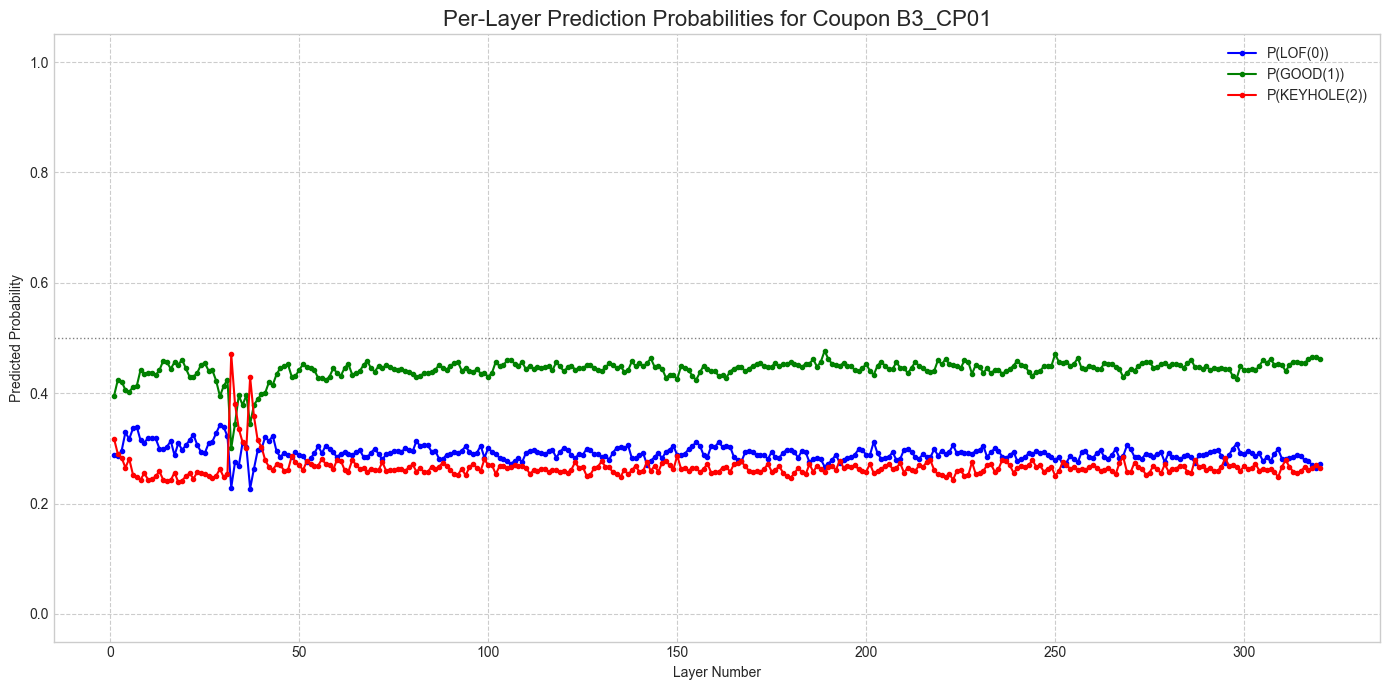

In [6]:
'''Cell 6: Run Layer-wise Prediction for a Specific Coupon'''
# ==============================================================================
# --- Configuration for this cell ---
COUPON_ID_TO_INSPECT = 'B3_CP01'  # <-- CHANGE THIS

if unlabeled_sequences:
    target_coupon = next((item for item in unlabeled_sequences if item['coupon_id'] == COUPON_ID_TO_INSPECT), None)

    if target_coupon:
        print(f"\n--- Running Layer-wise Analysis for Coupon: {COUPON_ID_TO_INSPECT} ---")
        sequence = target_coupon['sequence']
        
        with torch.no_grad():
            seq_batch = sequence.unsqueeze(0).to(DEVICE)
            length_tensor = torch.tensor([sequence.shape[0]], dtype=torch.long)
            mask_tensor = torch.ones(1, sequence.shape[0], dtype=torch.bool).to(DEVICE)
            
            all_logits = model(seq_batch, length_tensor, mask_tensor, return_all_outputs=True)
            all_probs = torch.softmax(all_logits, dim=-1).squeeze(0).cpu().numpy()
        
        df_layer = pd.DataFrame(all_probs, columns=[f"prob_{name}" for name in CLASS_NAMES])
        df_layer['layer'] = df_layer.index + 1
        
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(14, 7))
        plot_colors = ['blue', 'green', 'red']
        
        for i, class_name in enumerate(CLASS_NAMES):
            ax.plot(df_layer['layer'], df_layer[f'prob_{class_name}'], label=f"P({class_name})", color=plot_colors[i], marker='.')
        
        ax.set_title(f"Per-Layer Prediction Probabilities for Coupon {COUPON_ID_TO_INSPECT}", fontsize=16)
        ax.set_xlabel("Layer Number"); ax.set_ylabel("Predicted Probability")
        ax.set_ylim(-0.05, 1.05); ax.legend(loc='best'); ax.grid(True, linestyle='--')
        ax.axhline(y=0.5, color='gray', linestyle=':', linewidth=1)
        plt.tight_layout(); plt.show()
    else:
        print(f"\n⚠️ Coupon ID '{COUPON_ID_TO_INSPECT}' not found for layer-wise analysis.")